In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.model_selection import train_test_split
os.chdir('../..')

seed = 42

# Python built-in random
random.seed(seed)

# NumPy random
np.random.seed(seed)

# PyTorch random
torch.manual_seed(seed)

# For CUDA (if using GPU)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you’re using multi-GPU

# For deterministic behavior (optional but useful)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
with open('storage/gene_expressions_cleaned/tcga.pkl','rb') as f:
    tcga_data = pickle.load(f)
with open('storage/gene_expressions_cleaned/gdsc.pkl','rb') as f:
    gdsc_data = pickle.load(f)

In [3]:
all_data = np.concat([gdsc_data['data'],tcga_data['data']],axis=0)
# 0: gdsc 1:tcga
dataset_indicator = np.zeros(all_data.shape[0])
dataset_indicator[gdsc_data['data'].shape[0]:] = 1

In [4]:
tsne = TSNE(n_components=2, perplexity=30)
tsne_embeddings = tsne.fit_transform(all_data)

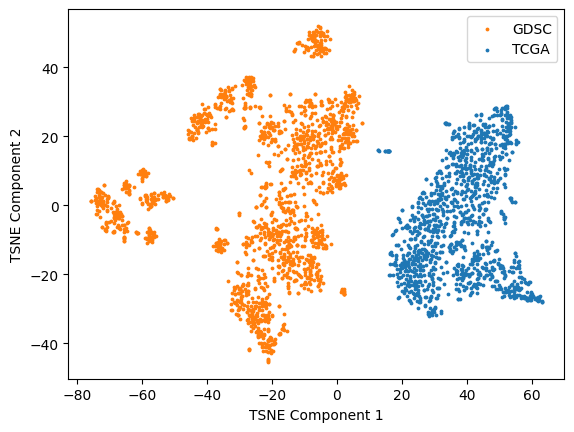

In [8]:
plt.figure()
gdsc_tsne = tsne_embeddings[:gdsc_data['data'].shape[0]]
tcga_tsne = tsne_embeddings[gdsc_data['data'].shape[0]:]
plt.scatter(gdsc_tsne[:,0],gdsc_tsne[:,1],s=3, c='tab:orange', label='GDSC')
plt.scatter(tcga_tsne[:,0],tcga_tsne[:,1],s=3, c='tab:blue', label='TCGA')
plt.xlabel('TSNE‌ Component 1')
plt.ylabel('TSNE‌ Component 2')
plt.legend()
plt.show()

In [9]:
print('tcga_stats(max,min): ',tcga_data['data'].max(), tcga_data['data'].min())
print('gdsc_stas(max,min): ',gdsc_data['data'].max(), gdsc_data['data'].min())

tcga_stats(max,min):  503643.66 0.0
gdsc_stas(max,min):  18.178 0.0


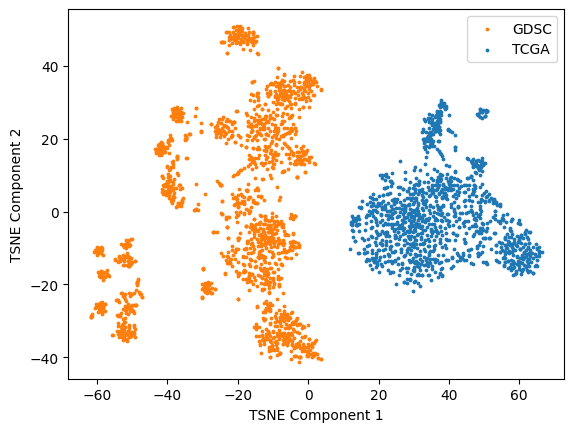

In [10]:
tsne = TSNE(n_components=2, perplexity=30)
log_transformed = np.log1p(all_data)
tsne_embeddings = tsne.fit_transform(log_transformed)

plt.figure()
gdsc_tsne = tsne_embeddings[:gdsc_data['data'].shape[0]]
tcga_tsne = tsne_embeddings[gdsc_data['data'].shape[0]:]
plt.scatter(gdsc_tsne[:,0],gdsc_tsne[:,1],s=3, c='tab:orange', label='GDSC')
plt.scatter(tcga_tsne[:,0],tcga_tsne[:,1],s=3, c='tab:blue', label='TCGA')
plt.xlabel('TSNE‌ Component 1')
plt.ylabel('TSNE‌ Component 2')
plt.legend()
plt.show()

In [11]:
print('tcga_stats(max,min): ',np.log1p(tcga_data['data']).max(), np.log1p(tcga_data['data']).min())
print('gdsc_stas(max,min): ',np.log1p(gdsc_data['data'].max()), np.log1p(gdsc_data['data']).min())

tcga_stats(max,min):  13.129626 0.0
gdsc_stas(max,min):  2.9537637 0.0


In [20]:
tcga_log_transformed = torch.tensor(np.log1p(tcga_data['data']), dtype=torch.float32)
gdsc_log_transformed = torch.tensor(np.log1p(gdsc_data['data']), dtype=torch.float32)

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

tcga_log_transformed = scaler.fit_transform(np.log1p(tcga_data['data']))
gdsc_log_transformed = scaler.fit_transform(np.log1p(gdsc_data['data']))

tcga_log_transformed = torch.tensor(tcga_log_transformed, dtype=torch.float32)
gdsc_log_transformed = torch.tensor(gdsc_log_transformed, dtype=torch.float32)

In [21]:
class LinearNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, act_class):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dims = hidden_dims
        self.act_class = act_class
        
        prev_dim = input_dim
        layers = []
        for hidden_dim in hidden_dims + [output_dim]:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            if hidden_dim != output_dim:
                layers.append(act_class())
            prev_dim = hidden_dim
        self.network = nn.Sequential(
            *layers
        )
    def forward(self,x):
        return self.network(x)

In [22]:
train_tcga, test_tcga = train_test_split(tcga_log_transformed, test_size=0.1, shuffle=True, random_state=42)
train_gdsc, test_gdsc = train_test_split(gdsc_log_transformed, test_size=0.1, shuffle=True, random_state=42)

## Vanila AutoEncdoer

In [23]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, act_class, layer_norm=False):
        super().__init__()
        self.input_dim = input_dim
        self.encoder = LinearNetwork(input_dim, output_dim, hidden_dims, act_class)
        self.decoder = LinearNetwork(output_dim, input_dim, hidden_dims[::-1], act_class)
        if layer_norm:
            self.layer_norm = nn.LayerNorm(input_dim)
        else:
            self.layer_norm = None
    
    def encode(self, x):
        return self.encoder(x)

    def forward(self,x):
        out = x
        if self.layer_norm:
            out = self.layer_norm(out)
        out = self.encoder(out)
        out = self.decoder(out)
        return out

In [24]:
INPUT_DIM = tcga_log_transformed.shape[1]
OUTPUT_DIM = 128
hidden_dims = [512,256]
model = AutoEncoder(INPUT_DIM, OUTPUT_DIM, hidden_dims, nn.ReLU, layer_norm=True)

In [25]:
all_data = torch.concat([gdsc_log_transformed, tcga_log_transformed], dim=0)
train_size = int(all_data.shape[0]*0.9)
random_indices = torch.randperm(all_data.shape[0])
train_data = all_data[random_indices[:train_size]]
test_data = all_data[random_indices[train_size:]]
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
EPOCHS = 1000
loss_fn = nn.MSELoss()

In [26]:
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    reconstruced = model(train_data)
    loss = loss_fn(reconstruced, train_data)
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        val_reconstructed = model(test_data)
        loss_val = loss_fn(val_reconstructed, test_data)
    print(f'epoch [{epoch+1}/{EPOCHS}]: loss_train:{loss.item():.4f} , loss_val:{loss_val.item():.4f}')

epoch [1/1000]: loss_train:11.1523 , loss_val:11.1118
epoch [2/1000]: loss_train:11.0088 , loss_val:10.5434
epoch [3/1000]: loss_train:10.4457 , loss_val:8.9721
epoch [4/1000]: loss_train:8.8893 , loss_val:5.7980
epoch [5/1000]: loss_train:5.7441 , loss_val:3.0416
epoch [6/1000]: loss_train:3.0057 , loss_val:5.3213
epoch [7/1000]: loss_train:5.2284 , loss_val:1.3880
epoch [8/1000]: loss_train:1.3679 , loss_val:0.9983
epoch [9/1000]: loss_train:1.0160 , loss_val:1.6132
epoch [10/1000]: loss_train:1.6426 , loss_val:1.7335
epoch [11/1000]: loss_train:1.7705 , loss_val:1.3826
epoch [12/1000]: loss_train:1.4238 , loss_val:1.1042
epoch [13/1000]: loss_train:1.1335 , loss_val:1.4950
epoch [14/1000]: loss_train:1.4876 , loss_val:1.8145
epoch [15/1000]: loss_train:1.7854 , loss_val:1.3021
epoch [16/1000]: loss_train:1.2933 , loss_val:0.8334
epoch [17/1000]: loss_train:0.8503 , loss_val:0.7658
epoch [18/1000]: loss_train:0.7930 , loss_val:0.7889
epoch [19/1000]: loss_train:0.8156 , loss_val:0.68

In [27]:
model.eval()
with torch.no_grad():
    gdsc_encoded = model.encode(gdsc_log_transformed).numpy()
    tcga_encoded = model.encode(tcga_log_transformed).numpy()

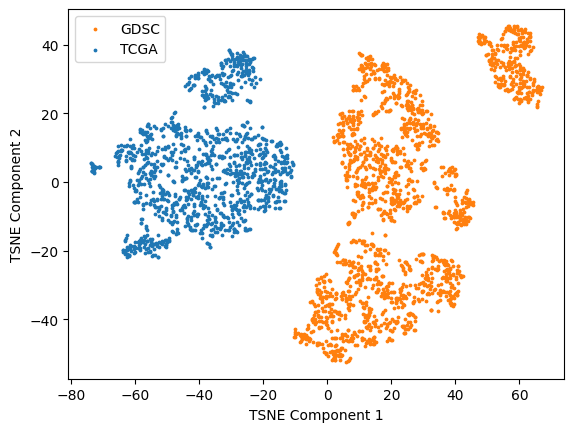

In [29]:
all_data = np.concat([gdsc_encoded,tcga_encoded],axis=0)
# 0: gdsc 1:tcga
dataset_indicator = np.zeros(all_data.shape[0])
dataset_indicator[gdsc_encoded.shape[0]:] = 1
tsne_embeddings = tsne.fit_transform(all_data)
plt.figure()
gdsc_tsne = tsne_embeddings[:gdsc_data['data'].shape[0]]
tcga_tsne = tsne_embeddings[gdsc_data['data'].shape[0]:]
plt.scatter(gdsc_tsne[:,0],gdsc_tsne[:,1],s=3, c='tab:orange', label='GDSC')
plt.scatter(tcga_tsne[:,0],tcga_tsne[:,1],s=3, c='tab:blue', label='TCGA')
plt.xlabel('TSNE‌ Component 1')
plt.ylabel('TSNE‌ Component 2')
plt.legend()
plt.show()

## CODE‌-AE-BASE

In [30]:
INPUT_DIM = tcga_log_transformed.shape[1]
EMBEDDING_DIM = 128
hidden_dims = [512,256]
ACT_CLASS = nn.ReLU

In [31]:
class CODEAEBase(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dims, act_class):
        super().__init__()
        self.shared_encoder = LinearNetwork(input_dim, embedding_dim, hidden_dims, act_class)
        self.patient_private_encoder = LinearNetwork(input_dim, embedding_dim, hidden_dims, act_class)
        self.cell_private_encoder = LinearNetwork(input_dim, embedding_dim, hidden_dims, act_class)
        self.decoder = LinearNetwork(embedding_dim * 2, input_dim, hidden_dims[::-1], act_class)
    
    def forward(self, x_tcga, x_gdsc):
        tcga_shared_embedding = self.shared_encoder(x_tcga)
        gdsc_shared_embedding = self.shared_encoder(x_gdsc)

        tcga_private_embedding = self.patient_private_encoder(x_tcga)
        gdsc_private_embedding = self.cell_private_encoder(x_gdsc)

        tcga_embedding = torch.concat([tcga_shared_embedding, tcga_private_embedding], dim=1)
        gdsc_embedding = torch.concat([gdsc_shared_embedding, gdsc_private_embedding], dim=1)

        tcga_reconstructed = self.decoder(tcga_embedding)
        gdsc_reconstructed = self.decoder(gdsc_embedding)

        loss_reconstruction = torch.norm((tcga_reconstructed - x_tcga)**2) / x_tcga.shape[0] + torch.norm((gdsc_reconstructed - x_gdsc)**2) / x_gdsc.shape[0]
        
        tcga_shared_embedding_norm = torch.norm(tcga_shared_embedding, p=2, dim=1, keepdim=True).detach()
        gdsc_shared_embedding_norm = torch.norm(gdsc_shared_embedding, p=2, dim=1, keepdim=True).detach()

        tcga_private_embedding_norm = torch.norm(tcga_private_embedding, p=2, dim=1, keepdim=True).detach()
        gdsc_private_embedding_norm = torch.norm(gdsc_private_embedding, p=2, dim=1, keepdim=True).detach()

        tcga_shared_embedding_l2 = tcga_shared_embedding.div(tcga_shared_embedding_norm.expand_as(tcga_shared_embedding) + 1e-6) 
        gdsc_shared_embedding_l2 = gdsc_shared_embedding.div(gdsc_shared_embedding_norm.expand_as(gdsc_shared_embedding) + 1e-6) 

        tcga_private_embedding_l2 = tcga_private_embedding.div(tcga_private_embedding_norm.expand_as(tcga_private_embedding) + 1e-6) 
        gdsc_private_embedding_l2 = gdsc_private_embedding.div(gdsc_private_embedding_norm.expand_as(gdsc_private_embedding) + 1e-6) 


        loss_diff = torch.mean((tcga_shared_embedding_l2.T @ tcga_private_embedding_l2).pow(2)) + torch.mean((gdsc_shared_embedding_l2.T @ gdsc_private_embedding_l2).pow(2))
        loss = loss_reconstruction + loss_diff

        return {
            'loss':loss,
            'loss_reconstruction': loss_reconstruction,
            'loss_diff': loss_diff,
            'tcga_embedding': tcga_shared_embedding,
            'gdsc_embedding': gdsc_shared_embedding
        }

In [46]:
model = CODEAEBase(INPUT_DIM, EMBEDDING_DIM, hidden_dims, ACT_CLASS)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
EPOCHS = 1000

Epoch [1/1000] loss:259.8163, loss_reconstruction:36.4873, loss_diff:223.3290
Epoch [2/1000] loss:252.8684, loss_reconstruction:36.4699, loss_diff:216.3985
Epoch [3/1000] loss:243.1409, loss_reconstruction:36.4576, loss_diff:206.6832
Epoch [4/1000] loss:232.5525, loss_reconstruction:36.4496, loss_diff:196.1030
Epoch [5/1000] loss:222.2422, loss_reconstruction:36.4436, loss_diff:185.7985
Epoch [6/1000] loss:211.0176, loss_reconstruction:36.4382, loss_diff:174.5794
Epoch [7/1000] loss:199.4583, loss_reconstruction:36.4318, loss_diff:163.0265
Epoch [8/1000] loss:187.6012, loss_reconstruction:36.4268, loss_diff:151.1743
Epoch [9/1000] loss:177.7844, loss_reconstruction:36.4225, loss_diff:141.3619
Epoch [10/1000] loss:170.1138, loss_reconstruction:36.4166, loss_diff:133.6972
Epoch [11/1000] loss:163.5062, loss_reconstruction:36.4102, loss_diff:127.0960
Epoch [12/1000] loss:157.8985, loss_reconstruction:36.4056, loss_diff:121.4930
Epoch [13/1000] loss:153.4804, loss_reconstruction:36.4016, l

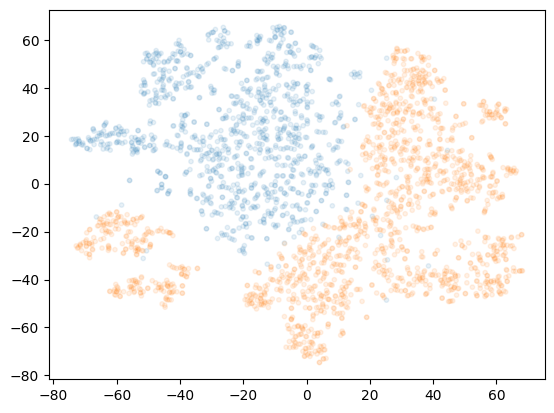

Epoch [51/1000] loss:44.6744, loss_reconstruction:36.0457, loss_diff:8.6287
Epoch [52/1000] loss:44.1405, loss_reconstruction:36.0327, loss_diff:8.1078
Epoch [53/1000] loss:43.6946, loss_reconstruction:36.0189, loss_diff:7.6757
Epoch [54/1000] loss:43.4798, loss_reconstruction:36.0049, loss_diff:7.4750
Epoch [55/1000] loss:43.2383, loss_reconstruction:35.9906, loss_diff:7.2477
Epoch [56/1000] loss:43.0157, loss_reconstruction:35.9762, loss_diff:7.0396
Epoch [57/1000] loss:42.8372, loss_reconstruction:35.9616, loss_diff:6.8756
Epoch [58/1000] loss:42.6596, loss_reconstruction:35.9469, loss_diff:6.7126
Epoch [59/1000] loss:42.5091, loss_reconstruction:35.9321, loss_diff:6.5770
Epoch [60/1000] loss:42.2534, loss_reconstruction:35.9170, loss_diff:6.3365
Epoch [61/1000] loss:42.0352, loss_reconstruction:35.9012, loss_diff:6.1340
Epoch [62/1000] loss:41.8402, loss_reconstruction:35.8850, loss_diff:5.9552
Epoch [63/1000] loss:41.6681, loss_reconstruction:35.8685, loss_diff:5.7996
Epoch [64/10

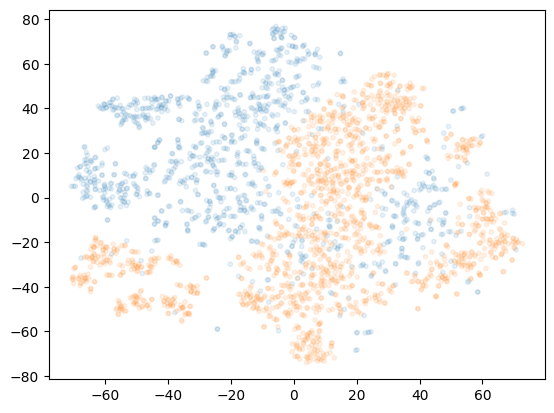

Epoch [101/1000] loss:37.8202, loss_reconstruction:34.9103, loss_diff:2.9099
Epoch [102/1000] loss:37.6168, loss_reconstruction:34.8721, loss_diff:2.7447
Epoch [103/1000] loss:37.3615, loss_reconstruction:34.8359, loss_diff:2.5256
Epoch [104/1000] loss:37.3635, loss_reconstruction:34.7982, loss_diff:2.5653
Epoch [105/1000] loss:37.3907, loss_reconstruction:34.7586, loss_diff:2.6321
Epoch [106/1000] loss:37.1976, loss_reconstruction:34.7202, loss_diff:2.4774
Epoch [107/1000] loss:37.0009, loss_reconstruction:34.6781, loss_diff:2.3228
Epoch [108/1000] loss:36.9836, loss_reconstruction:34.6363, loss_diff:2.3473
Epoch [109/1000] loss:36.9798, loss_reconstruction:34.5936, loss_diff:2.3862
Epoch [110/1000] loss:36.8372, loss_reconstruction:34.5490, loss_diff:2.2882
Epoch [111/1000] loss:36.6542, loss_reconstruction:34.5046, loss_diff:2.1496
Epoch [112/1000] loss:36.5571, loss_reconstruction:34.4591, loss_diff:2.0981
Epoch [113/1000] loss:36.5447, loss_reconstruction:34.4099, loss_diff:2.1348

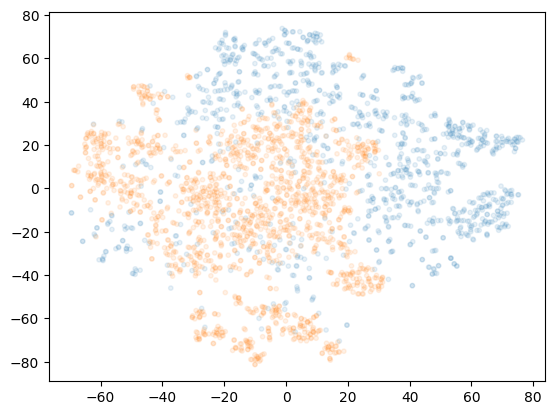

Epoch [151/1000] loss:33.9326, loss_reconstruction:32.1113, loss_diff:1.8214
Epoch [152/1000] loss:34.0445, loss_reconstruction:32.0183, loss_diff:2.0262
Epoch [153/1000] loss:33.8349, loss_reconstruction:31.9307, loss_diff:1.9042
Epoch [154/1000] loss:33.6053, loss_reconstruction:31.8260, loss_diff:1.7793
Epoch [155/1000] loss:33.4125, loss_reconstruction:31.7393, loss_diff:1.6732
Epoch [156/1000] loss:33.1932, loss_reconstruction:31.6363, loss_diff:1.5569
Epoch [157/1000] loss:33.1890, loss_reconstruction:31.5243, loss_diff:1.6648
Epoch [158/1000] loss:33.4454, loss_reconstruction:31.4334, loss_diff:2.0119
Epoch [159/1000] loss:34.3501, loss_reconstruction:31.2952, loss_diff:3.0549
Epoch [160/1000] loss:37.0760, loss_reconstruction:31.2628, loss_diff:5.8133
Epoch [161/1000] loss:37.8204, loss_reconstruction:31.1826, loss_diff:6.6378
Epoch [162/1000] loss:34.4919, loss_reconstruction:31.2647, loss_diff:3.2272
Epoch [163/1000] loss:35.0264, loss_reconstruction:31.2928, loss_diff:3.7335

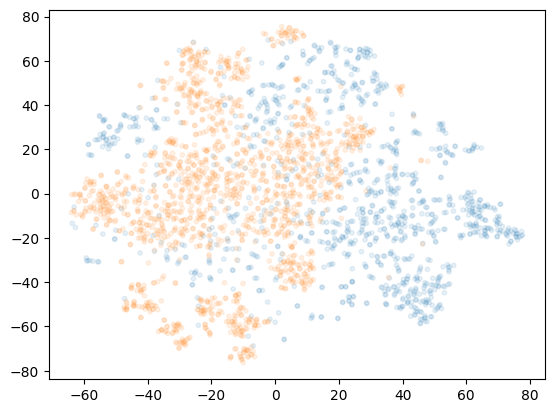

Epoch [201/1000] loss:30.3570, loss_reconstruction:27.3113, loss_diff:3.0457
Epoch [202/1000] loss:30.2305, loss_reconstruction:27.0975, loss_diff:3.1330
Epoch [203/1000] loss:29.7766, loss_reconstruction:27.0138, loss_diff:2.7628
Epoch [204/1000] loss:30.0510, loss_reconstruction:26.9001, loss_diff:3.1509
Epoch [205/1000] loss:28.9165, loss_reconstruction:26.6083, loss_diff:2.3082
Epoch [206/1000] loss:29.2132, loss_reconstruction:26.3738, loss_diff:2.8393
Epoch [207/1000] loss:28.7799, loss_reconstruction:26.2188, loss_diff:2.5611
Epoch [208/1000] loss:27.9831, loss_reconstruction:25.9592, loss_diff:2.0239
Epoch [209/1000] loss:28.7346, loss_reconstruction:25.6886, loss_diff:3.0460
Epoch [210/1000] loss:28.0002, loss_reconstruction:25.5747, loss_diff:2.4255
Epoch [211/1000] loss:27.1251, loss_reconstruction:25.3281, loss_diff:1.7970
Epoch [212/1000] loss:27.8516, loss_reconstruction:25.0757, loss_diff:2.7759
Epoch [213/1000] loss:27.3456, loss_reconstruction:24.9596, loss_diff:2.3859

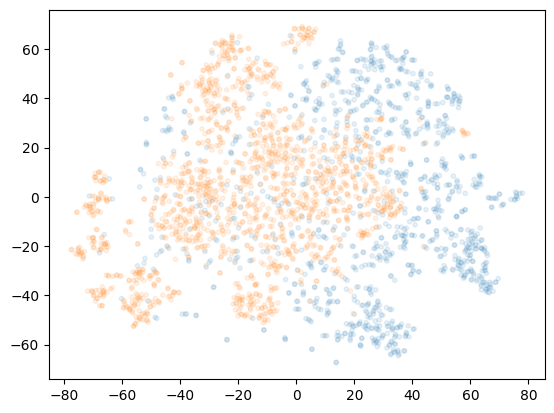

Epoch [251/1000] loss:21.0420, loss_reconstruction:16.4296, loss_diff:4.6124
Epoch [252/1000] loss:23.1485, loss_reconstruction:16.1446, loss_diff:7.0039
Epoch [253/1000] loss:24.5010, loss_reconstruction:16.3715, loss_diff:8.1295
Epoch [254/1000] loss:22.3697, loss_reconstruction:16.5587, loss_diff:5.8110
Epoch [255/1000] loss:20.6238, loss_reconstruction:17.2959, loss_diff:3.3279
Epoch [256/1000] loss:21.0388, loss_reconstruction:17.4005, loss_diff:3.6384
Epoch [257/1000] loss:21.3755, loss_reconstruction:16.9610, loss_diff:4.4145
Epoch [258/1000] loss:20.5878, loss_reconstruction:16.7043, loss_diff:3.8835
Epoch [259/1000] loss:18.9865, loss_reconstruction:15.9716, loss_diff:3.0149
Epoch [260/1000] loss:18.6006, loss_reconstruction:15.2991, loss_diff:3.3016
Epoch [261/1000] loss:18.8720, loss_reconstruction:15.0842, loss_diff:3.7878
Epoch [262/1000] loss:18.3331, loss_reconstruction:14.4563, loss_diff:3.8768
Epoch [263/1000] loss:17.7056, loss_reconstruction:14.2129, loss_diff:3.4927

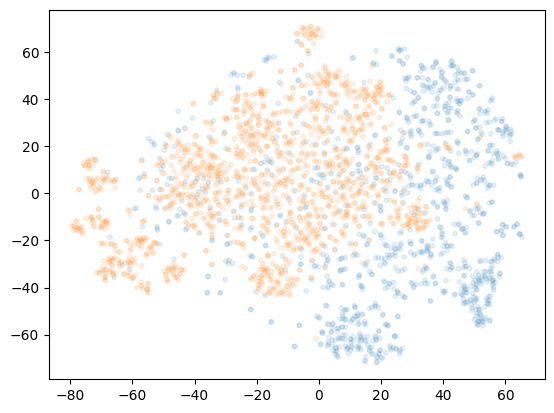

Epoch [301/1000] loss:5.8832, loss_reconstruction:3.6810, loss_diff:2.2022
Epoch [302/1000] loss:5.2760, loss_reconstruction:3.7017, loss_diff:1.5743
Epoch [303/1000] loss:5.2674, loss_reconstruction:3.6445, loss_diff:1.6228
Epoch [304/1000] loss:5.5469, loss_reconstruction:3.5505, loss_diff:1.9964
Epoch [305/1000] loss:5.3095, loss_reconstruction:3.4561, loss_diff:1.8534
Epoch [306/1000] loss:4.8984, loss_reconstruction:3.4210, loss_diff:1.4773
Epoch [307/1000] loss:4.6650, loss_reconstruction:3.4593, loss_diff:1.2057
Epoch [308/1000] loss:4.6919, loss_reconstruction:3.4908, loss_diff:1.2011
Epoch [309/1000] loss:4.9298, loss_reconstruction:3.5172, loss_diff:1.4126
Epoch [310/1000] loss:5.0440, loss_reconstruction:3.4709, loss_diff:1.5732
Epoch [311/1000] loss:4.7950, loss_reconstruction:3.4042, loss_diff:1.3909
Epoch [312/1000] loss:4.4208, loss_reconstruction:3.2910, loss_diff:1.1297
Epoch [313/1000] loss:4.2497, loss_reconstruction:3.1821, loss_diff:1.0676
Epoch [314/1000] loss:4.1

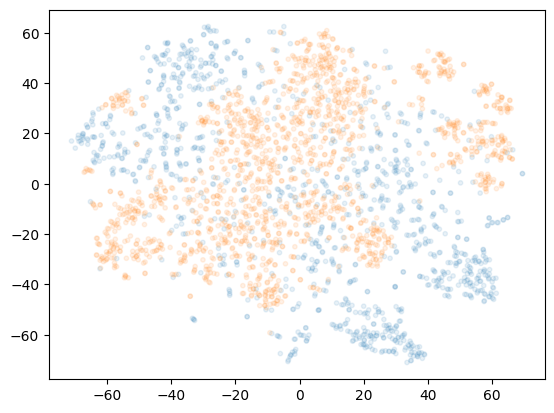

Epoch [351/1000] loss:6.7533, loss_reconstruction:2.8788, loss_diff:3.8744
Epoch [352/1000] loss:5.2699, loss_reconstruction:2.7332, loss_diff:2.5366
Epoch [353/1000] loss:4.3660, loss_reconstruction:2.5832, loss_diff:1.7827
Epoch [354/1000] loss:4.9912, loss_reconstruction:2.4519, loss_diff:2.5393
Epoch [355/1000] loss:4.8376, loss_reconstruction:2.3892, loss_diff:2.4484
Epoch [356/1000] loss:4.3449, loss_reconstruction:2.3338, loss_diff:2.0111
Epoch [357/1000] loss:4.0367, loss_reconstruction:2.3145, loss_diff:1.7222
Epoch [358/1000] loss:4.3406, loss_reconstruction:2.3087, loss_diff:2.0320
Epoch [359/1000] loss:4.0886, loss_reconstruction:2.2917, loss_diff:1.7970
Epoch [360/1000] loss:3.9268, loss_reconstruction:2.2977, loss_diff:1.6290
Epoch [361/1000] loss:3.7831, loss_reconstruction:2.2980, loss_diff:1.4851
Epoch [362/1000] loss:3.9255, loss_reconstruction:2.2894, loss_diff:1.6361
Epoch [363/1000] loss:3.6980, loss_reconstruction:2.3052, loss_diff:1.3928
Epoch [364/1000] loss:3.6

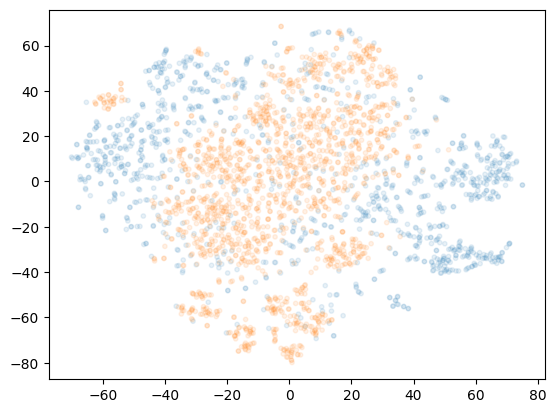

Epoch [401/1000] loss:4.6932, loss_reconstruction:2.2556, loss_diff:2.4376
Epoch [402/1000] loss:5.0085, loss_reconstruction:2.4655, loss_diff:2.5430
Epoch [403/1000] loss:4.0921, loss_reconstruction:2.5673, loss_diff:1.5247
Epoch [404/1000] loss:4.0397, loss_reconstruction:2.6475, loss_diff:1.3923
Epoch [405/1000] loss:4.6267, loss_reconstruction:2.7165, loss_diff:1.9102
Epoch [406/1000] loss:4.2484, loss_reconstruction:2.6253, loss_diff:1.6231
Epoch [407/1000] loss:3.9158, loss_reconstruction:2.5482, loss_diff:1.3676
Epoch [408/1000] loss:3.9883, loss_reconstruction:2.4069, loss_diff:1.5814
Epoch [409/1000] loss:3.4932, loss_reconstruction:2.2516, loss_diff:1.2416
Epoch [410/1000] loss:3.3873, loss_reconstruction:2.1543, loss_diff:1.2330
Epoch [411/1000] loss:3.6726, loss_reconstruction:2.0719, loss_diff:1.6007
Epoch [412/1000] loss:3.4899, loss_reconstruction:2.0500, loss_diff:1.4399
Epoch [413/1000] loss:3.2987, loss_reconstruction:2.0523, loss_diff:1.2464
Epoch [414/1000] loss:3.2

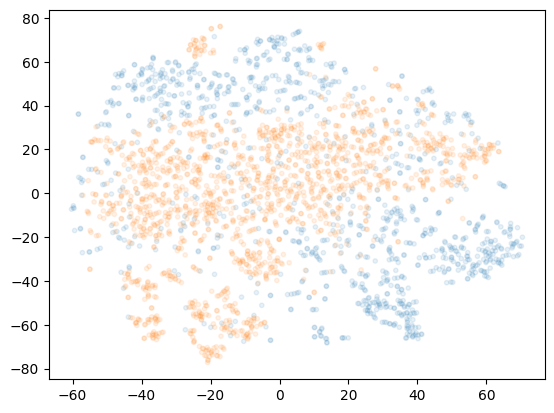

Epoch [451/1000] loss:2.8065, loss_reconstruction:2.0037, loss_diff:0.8028
Epoch [452/1000] loss:2.8870, loss_reconstruction:1.9965, loss_diff:0.8905
Epoch [453/1000] loss:2.9979, loss_reconstruction:1.9911, loss_diff:1.0068
Epoch [454/1000] loss:3.1755, loss_reconstruction:1.9937, loss_diff:1.1818
Epoch [455/1000] loss:3.3657, loss_reconstruction:2.0071, loss_diff:1.3586
Epoch [456/1000] loss:3.5498, loss_reconstruction:2.0276, loss_diff:1.5222
Epoch [457/1000] loss:3.6609, loss_reconstruction:2.0679, loss_diff:1.5930
Epoch [458/1000] loss:3.6484, loss_reconstruction:2.0973, loss_diff:1.5511
Epoch [459/1000] loss:3.5071, loss_reconstruction:2.1430, loss_diff:1.3641
Epoch [460/1000] loss:3.2940, loss_reconstruction:2.1546, loss_diff:1.1394
Epoch [461/1000] loss:3.0595, loss_reconstruction:2.1512, loss_diff:0.9083
Epoch [462/1000] loss:2.8732, loss_reconstruction:2.1157, loss_diff:0.7576
Epoch [463/1000] loss:2.7367, loss_reconstruction:2.0656, loss_diff:0.6712
Epoch [464/1000] loss:2.6

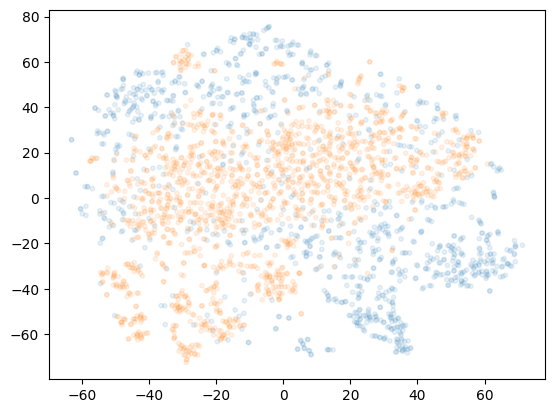

Epoch [501/1000] loss:3.1900, loss_reconstruction:1.9718, loss_diff:1.2182


KeyboardInterrupt: 

In [47]:
model.train()
plot_per_epoch = 50
tsne = TSNE(n_components=2, perplexity=10)
loss_history = []
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    out = model(train_tcga, train_gdsc)
    loss = out['loss']
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{EPOCHS}] loss:{loss.item():.4f}, loss_reconstruction:{out['loss_reconstruction'].item():.4f}, loss_diff:{out['loss_diff'].item():.4f}')
    loss_history.append(loss.item())
    if (epoch+1) % plot_per_epoch == 0:
        print('Plot the shared space...')
        plt.figure()
        tcga_embedding = out['tcga_embedding'].detach().numpy()
        gdsc_embedding = out['gdsc_embedding'].detach().numpy()
        all_embeddings = np.concat([tcga_embedding, gdsc_embedding], axis=0)
        tsne_embeddings = tsne.fit_transform(all_embeddings)
        colors = ['tab:blue' if i < tcga_embedding.shape[0] else 'tab:orange'  for i in range(tsne_embeddings.shape[0])]
        plt.scatter(tsne_embeddings[:,0],tsne_embeddings[:,1], c=colors, s=10, alpha=0.1)
        plt.show()

Plot the shared space...


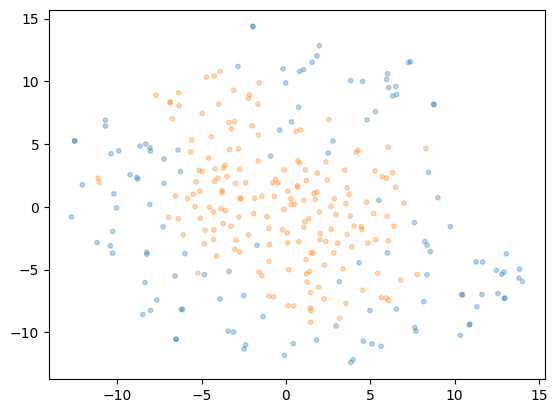

In [48]:
tsne = TSNE(n_components=2, perplexity=30)
model.eval()
with torch.no_grad():
    out = model(test_tcga, test_gdsc)

print('Plot the shared space...')
plt.figure()
tcga_embedding = out['tcga_embedding'].detach().numpy()
gdsc_embedding = out['gdsc_embedding'].detach().numpy()
all_embeddings = np.concat([tcga_embedding, gdsc_embedding], axis=0)
tsne_embeddings = tsne.fit_transform(all_embeddings)
colors = ['tab:blue' if i < tcga_embedding.shape[0] else 'tab:orange'  for i in range(tsne_embeddings.shape[0])]
plt.scatter(tsne_embeddings[:,0],tsne_embeddings[:,1], c=colors, s=10, alpha=0.3)
plt.show()

## CODE-AE-MMD

In [49]:
""" Source https://github.com/XieResearchGroup/CODE-AE/blob/main/code/loss_and_metrics.py"""
import torch
from torch.autograd import Variable
from functools import partial


def cov(m, rowvar=False):
    """Estimate a covariance matrix given data.

    Covariance indicates the level to which two variables vary together.
    If we examine N-dimensional samples, `X = [x_1, x_2, ... x_N]^T`,
    then the covariance matrix element `C_{ij}` is the covariance of
    `x_i` and `x_j`. The element `C_{ii}` is the variance of `x_i`.

    Args:
        m: A 1-D or 2-D array containing multiple variables and observations.
            Each row of `m` represents a variable, and each column a single
            observation of all those variables.
        rowvar: If `rowvar` is True, then each row represents a
            variable, with observations in the columns. Otherwise, the
            relationship is transposed: each column represents a variable,
            while the rows contain observations.

    Returns:
        The covariance matrix of the variables.
    """
    if m.dim() > 2:
        raise ValueError('m has more than 2 dimensions')
    if m.dim() < 2:
        m = m.view(1, -1)
    if not rowvar and m.size(0) != 1:
        m = m.t()
    # m = m.type(torch.double)  # uncomment this line if desired
    fact = 1.0 / (m.size(1) - 1)
    m -= torch.mean(m, dim=1, keepdim=True)
    mt = m.t()  # if complex: mt = m.t().conj()
    return fact * m.matmul(mt).squeeze()


def pairwise_distance(x, y):
    if not len(x.shape) == len(y.shape) == 2:
        raise ValueError('Both inputs should be matrices.')

    if x.shape[1] != y.shape[1]:
        raise ValueError('The number of features should be the same.')

    x = x.view(x.shape[0], x.shape[1], 1)
    y = torch.transpose(y, 0, 1)
    output = torch.sum((x - y) ** 2, 1)
    output = torch.transpose(output, 0, 1)

    return output


def gaussian_kernel_matrix(x, y, sigmas):
    sigmas = sigmas.view(sigmas.shape[0], 1)
    beta = 1. / (2. * sigmas)
    dist = pairwise_distance(x, y).contiguous()
    dist_ = dist.view(1, -1)
    s = torch.matmul(beta, dist_)

    return torch.sum(torch.exp(-s), 0).view_as(dist)


def maximum_mean_discrepancy(x, y, kernel=gaussian_kernel_matrix):
    cost = torch.mean(kernel(x, x))
    cost += torch.mean(kernel(y, y))
    cost -= 2 * torch.mean(kernel(x, y))

    return cost


def mmd_loss(source_features, target_features, device):
    sigmas = [
        1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 15, 20, 25, 30, 35, 100,
        1e3, 1e4, 1e5, 1e6
    ]
    gaussian_kernel = partial(
        gaussian_kernel_matrix, sigmas=Variable(torch.Tensor(sigmas), requires_grad=False).to(device)
    )

    loss_value = maximum_mean_discrepancy(source_features, target_features, kernel=gaussian_kernel)
    loss_value = loss_value

    return loss_value

In [50]:
INPUT_DIM = tcga_log_transformed.shape[1]
EMBEDDING_DIM = 128
hidden_dims = [512,256]
ACT_CLASS = nn.ReLU
DEVICE = 'cpu'


In [51]:
class CODEAEMMD(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dims, act_class):
        super().__init__()
        self.shared_encoder = LinearNetwork(input_dim, embedding_dim, hidden_dims, act_class)
        self.patient_private_encoder = LinearNetwork(input_dim, embedding_dim, hidden_dims, act_class)
        self.cell_private_encoder = LinearNetwork(input_dim, embedding_dim, hidden_dims, act_class)
        self.decoder = LinearNetwork(embedding_dim * 2, input_dim, hidden_dims[::-1], act_class)
    
    def forward(self, x_tcga, x_gdsc):
        tcga_shared_embedding = self.shared_encoder(x_tcga)
        gdsc_shared_embedding = self.shared_encoder(x_gdsc)

        tcga_private_embedding = self.patient_private_encoder(x_tcga)
        gdsc_private_embedding = self.cell_private_encoder(x_gdsc)

        tcga_embedding = torch.concat([tcga_shared_embedding, tcga_private_embedding], dim=1)
        gdsc_embedding = torch.concat([gdsc_shared_embedding, gdsc_private_embedding], dim=1)

        tcga_reconstructed = self.decoder(tcga_embedding)
        gdsc_reconstructed = self.decoder(gdsc_embedding)

        loss_reconstruction = torch.norm((tcga_reconstructed - x_tcga)**2) / x_tcga.shape[0] + torch.norm((gdsc_reconstructed - x_gdsc)**2) / x_gdsc.shape[0]
        loss_diff = torch.norm(tcga_shared_embedding.T @ tcga_private_embedding) + torch.norm(gdsc_shared_embedding.T @ gdsc_private_embedding)
        loss_mmd = mmd_loss(gdsc_embedding, tcga_embedding, device=DEVICE)
        loss = loss_reconstruction + loss_diff + loss_mmd

        return {
            'loss':loss,
            'loss_reconstruction': loss_reconstruction,
            'loss_diff': loss_diff,
            'loss_mmd': loss_mmd,
            'tcga_embedding': tcga_shared_embedding,
            'gdsc_embedding': gdsc_shared_embedding
        }

In [56]:
model = CODEAEMMD(INPUT_DIM, EMBEDDING_DIM, hidden_dims, ACT_CLASS)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
EPOCHS = 100

In [57]:
train_tcga_dataset = torch.utils.data.TensorDataset(train_tcga)
train_gdsc_dataset = torch.utils.data.TensorDataset(train_gdsc)

In [58]:
BATCH_SIZE= 16
train_tcga_loader = torch.utils.data.DataLoader(train_tcga_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_gdsc_loader = torch.utils.data.DataLoader(train_gdsc_dataset, batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch [1/100] loss:588.0422, loss_reconstruction:581.5578, loss_diff:2.5013, loss_mmd:3.9831: 100%|██████████| 70/70 [00:02<00:00, 32.20it/s] 


Plot the shared space...


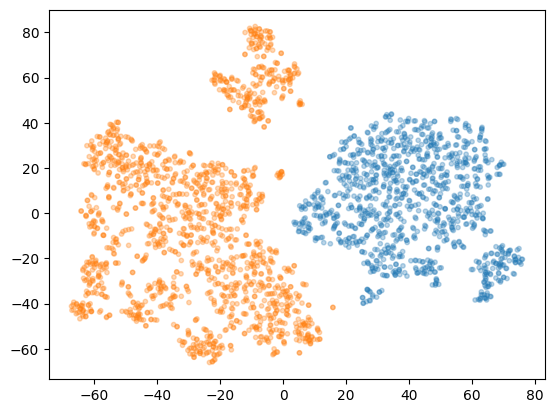

Epoch [2/100] loss:44.6201, loss_reconstruction:31.3420, loss_diff:4.5137, loss_mmd:8.7644: 100%|██████████| 70/70 [00:02<00:00, 31.82it/s]   
Epoch [3/100] loss:33.2139, loss_reconstruction:24.6347, loss_diff:1.5930, loss_mmd:6.9862: 100%|██████████| 70/70 [00:02<00:00, 33.42it/s] 
Epoch [4/100] loss:35.3179, loss_reconstruction:28.6906, loss_diff:1.2349, loss_mmd:5.3924: 100%|██████████| 70/70 [00:02<00:00, 34.26it/s]
Epoch [5/100] loss:33.5915, loss_reconstruction:27.5866, loss_diff:1.1925, loss_mmd:4.8124: 100%|██████████| 70/70 [00:02<00:00, 33.02it/s]
Epoch [6/100] loss:35.2489, loss_reconstruction:30.1121, loss_diff:0.8699, loss_mmd:4.2669: 100%|██████████| 70/70 [00:02<00:00, 34.19it/s]
Epoch [7/100] loss:32.6026, loss_reconstruction:28.1383, loss_diff:0.7550, loss_mmd:3.7093: 100%|██████████| 70/70 [00:02<00:00, 32.69it/s]
Epoch [8/100] loss:28.0943, loss_reconstruction:23.7098, loss_diff:0.6494, loss_mmd:3.7352: 100%|██████████| 70/70 [00:02<00:00, 33.23it/s]
Epoch [9/100] lo

Plot the shared space...


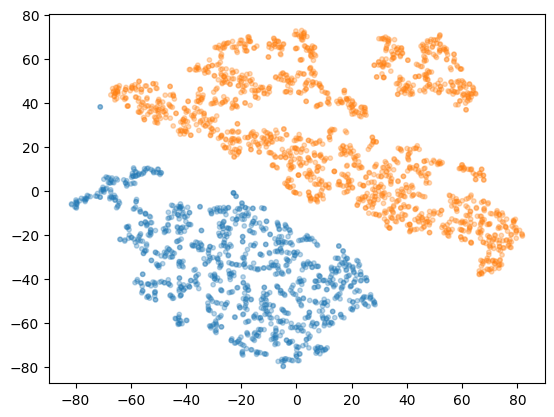

Epoch [11/100] loss:28.7013, loss_reconstruction:24.3560, loss_diff:0.7200, loss_mmd:3.6254: 100%|██████████| 70/70 [00:03<00:00, 20.94it/s]
Epoch [12/100] loss:43.7412, loss_reconstruction:39.5055, loss_diff:0.6672, loss_mmd:3.5685: 100%|██████████| 70/70 [00:05<00:00, 13.87it/s]
Epoch [13/100] loss:23.3834, loss_reconstruction:18.9584, loss_diff:0.6173, loss_mmd:3.8078: 100%|██████████| 70/70 [00:05<00:00, 13.46it/s]
Epoch [14/100] loss:26.9541, loss_reconstruction:23.2186, loss_diff:0.6049, loss_mmd:3.1306: 100%|██████████| 70/70 [00:04<00:00, 16.02it/s]
Epoch [15/100] loss:25.0931, loss_reconstruction:21.3943, loss_diff:0.4450, loss_mmd:3.2538: 100%|██████████| 70/70 [00:04<00:00, 17.18it/s]
Epoch [16/100] loss:25.0224, loss_reconstruction:21.2668, loss_diff:0.5302, loss_mmd:3.2253: 100%|██████████| 70/70 [00:04<00:00, 16.67it/s]
Epoch [17/100] loss:34.1015, loss_reconstruction:30.0364, loss_diff:0.5831, loss_mmd:3.4820: 100%|██████████| 70/70 [00:03<00:00, 17.75it/s]
Epoch [18/100

Plot the shared space...


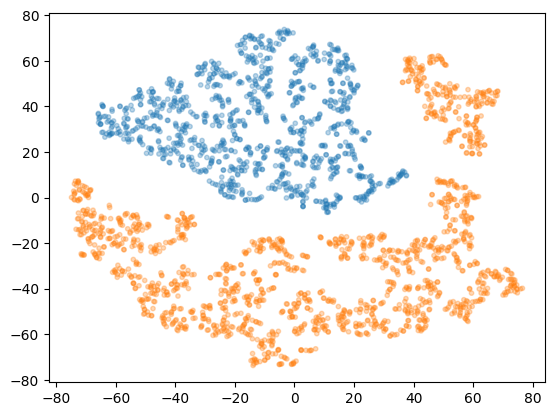

Epoch [21/100] loss:17.2052, loss_reconstruction:13.5786, loss_diff:0.4106, loss_mmd:3.2159: 100%|██████████| 70/70 [00:05<00:00, 13.55it/s]
Epoch [22/100] loss:24.6303, loss_reconstruction:20.9715, loss_diff:0.3731, loss_mmd:3.2857: 100%|██████████| 70/70 [00:04<00:00, 15.36it/s]
Epoch [23/100] loss:19.3198, loss_reconstruction:15.8217, loss_diff:0.3563, loss_mmd:3.1417: 100%|██████████| 70/70 [00:05<00:00, 13.97it/s]
Epoch [24/100] loss:19.3871, loss_reconstruction:15.7530, loss_diff:0.3955, loss_mmd:3.2386: 100%|██████████| 70/70 [00:04<00:00, 15.39it/s]
Epoch [25/100] loss:24.0602, loss_reconstruction:20.5119, loss_diff:0.4767, loss_mmd:3.0717: 100%|██████████| 70/70 [00:04<00:00, 16.34it/s]
Epoch [26/100] loss:24.2016, loss_reconstruction:20.8448, loss_diff:0.3762, loss_mmd:2.9805: 100%|██████████| 70/70 [00:04<00:00, 16.29it/s]
Epoch [27/100] loss:21.9737, loss_reconstruction:18.5673, loss_diff:0.4179, loss_mmd:2.9884: 100%|██████████| 70/70 [00:04<00:00, 15.93it/s]
Epoch [28/100

Plot the shared space...


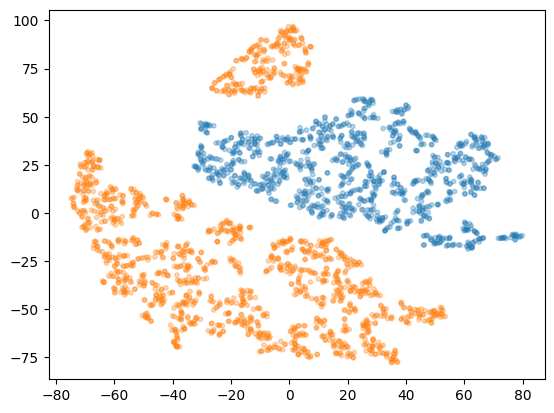

Epoch [31/100] loss:31.3567, loss_reconstruction:27.4498, loss_diff:0.4592, loss_mmd:3.4477: 100%|██████████| 70/70 [00:04<00:00, 14.08it/s]
Epoch [32/100] loss:21.3355, loss_reconstruction:17.7672, loss_diff:0.3306, loss_mmd:3.2377: 100%|██████████| 70/70 [00:04<00:00, 14.65it/s]
Epoch [33/100] loss:14.2268, loss_reconstruction:11.2554, loss_diff:0.2696, loss_mmd:2.7018: 100%|██████████| 70/70 [00:05<00:00, 12.89it/s]
Epoch [34/100] loss:15.6573, loss_reconstruction:12.3544, loss_diff:0.2889, loss_mmd:3.0141: 100%|██████████| 70/70 [00:05<00:00, 13.02it/s]
Epoch [35/100] loss:16.7336, loss_reconstruction:13.2022, loss_diff:0.2827, loss_mmd:3.2487: 100%|██████████| 70/70 [00:05<00:00, 13.08it/s]
Epoch [36/100] loss:15.3746, loss_reconstruction:12.1213, loss_diff:0.2992, loss_mmd:2.9541: 100%|██████████| 70/70 [00:05<00:00, 12.89it/s]
Epoch [37/100] loss:24.6068, loss_reconstruction:21.1179, loss_diff:0.3208, loss_mmd:3.1681: 100%|██████████| 70/70 [00:05<00:00, 13.82it/s]
Epoch [38/100

Plot the shared space...


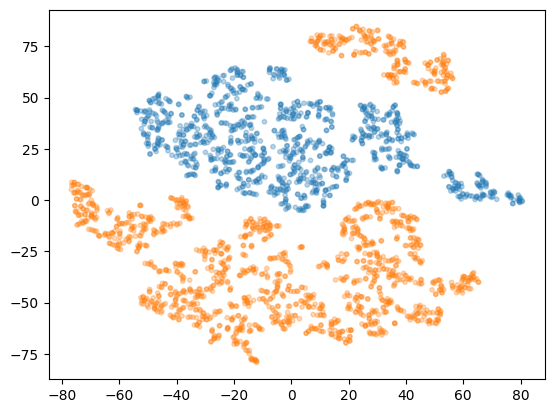

Epoch [41/100] loss:17.0941, loss_reconstruction:13.9778, loss_diff:0.2894, loss_mmd:2.8269: 100%|██████████| 70/70 [00:04<00:00, 16.87it/s]
Epoch [42/100] loss:17.2048, loss_reconstruction:13.9324, loss_diff:0.2112, loss_mmd:3.0613: 100%|██████████| 70/70 [00:04<00:00, 15.43it/s]
Epoch [43/100] loss:19.3515, loss_reconstruction:15.6405, loss_diff:0.3339, loss_mmd:3.3771: 100%|██████████| 70/70 [00:04<00:00, 14.91it/s]
Epoch [44/100] loss:18.6179, loss_reconstruction:15.3626, loss_diff:0.2639, loss_mmd:2.9914: 100%|██████████| 70/70 [00:04<00:00, 14.33it/s]
Epoch [45/100] loss:26.3356, loss_reconstruction:23.0649, loss_diff:0.2722, loss_mmd:2.9986: 100%|██████████| 70/70 [00:04<00:00, 15.00it/s]
Epoch [46/100] loss:21.6051, loss_reconstruction:18.5190, loss_diff:0.2648, loss_mmd:2.8213: 100%|██████████| 70/70 [00:04<00:00, 14.51it/s]
Epoch [47/100] loss:15.1613, loss_reconstruction:12.0066, loss_diff:0.2430, loss_mmd:2.9118: 100%|██████████| 70/70 [00:05<00:00, 13.38it/s]
Epoch [48/100

Plot the shared space...


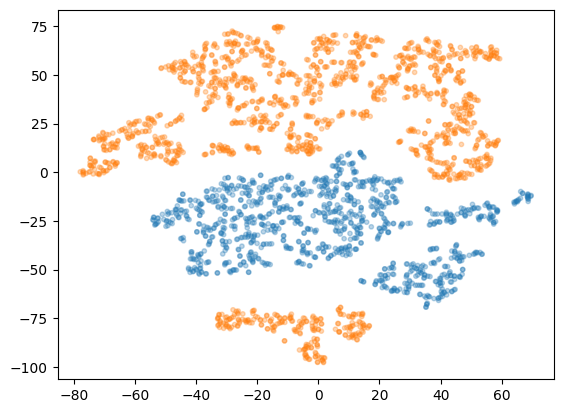

Epoch [51/100] loss:17.4427, loss_reconstruction:14.0000, loss_diff:0.2316, loss_mmd:3.2112: 100%|██████████| 70/70 [00:04<00:00, 14.21it/s]
Epoch [52/100] loss:22.3527, loss_reconstruction:18.9817, loss_diff:0.2942, loss_mmd:3.0768: 100%|██████████| 70/70 [00:05<00:00, 13.41it/s]
Epoch [53/100] loss:18.3216, loss_reconstruction:15.2380, loss_diff:0.2257, loss_mmd:2.8580: 100%|██████████| 70/70 [00:05<00:00, 13.23it/s]
Epoch [54/100] loss:19.1812, loss_reconstruction:16.1914, loss_diff:0.2169, loss_mmd:2.7729: 100%|██████████| 70/70 [00:05<00:00, 12.76it/s]
Epoch [55/100] loss:15.2852, loss_reconstruction:12.2281, loss_diff:0.2434, loss_mmd:2.8137: 100%|██████████| 70/70 [00:05<00:00, 13.06it/s]
Epoch [56/100] loss:17.9285, loss_reconstruction:14.6634, loss_diff:0.1947, loss_mmd:3.0704: 100%|██████████| 70/70 [00:04<00:00, 14.09it/s]
Epoch [57/100] loss:13.7826, loss_reconstruction:10.7604, loss_diff:0.1951, loss_mmd:2.8271: 100%|██████████| 70/70 [00:06<00:00, 11.20it/s]
Epoch [58/100

Plot the shared space...


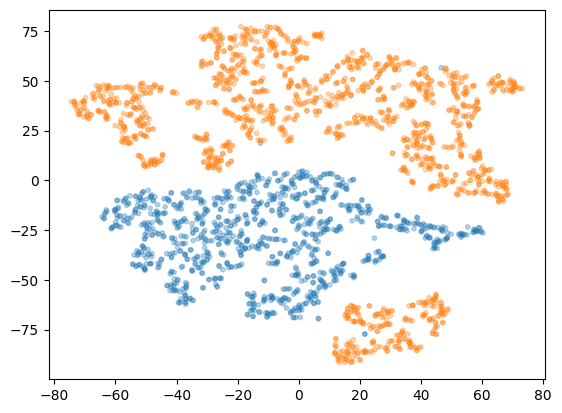

Epoch [61/100] loss:18.8868, loss_reconstruction:15.6592, loss_diff:0.2033, loss_mmd:3.0243: 100%|██████████| 70/70 [00:04<00:00, 14.29it/s]
Epoch [62/100] loss:17.6800, loss_reconstruction:14.5200, loss_diff:0.1739, loss_mmd:2.9861: 100%|██████████| 70/70 [00:05<00:00, 12.66it/s]
Epoch [63/100] loss:13.3844, loss_reconstruction:9.8559, loss_diff:0.2113, loss_mmd:3.3173: 100%|██████████| 70/70 [00:04<00:00, 14.18it/s]
Epoch [64/100] loss:15.0363, loss_reconstruction:12.1469, loss_diff:0.1908, loss_mmd:2.6987: 100%|██████████| 70/70 [00:05<00:00, 13.97it/s]
Epoch [65/100] loss:15.9101, loss_reconstruction:12.9270, loss_diff:0.1881, loss_mmd:2.7950: 100%|██████████| 70/70 [00:04<00:00, 15.70it/s]
Epoch [66/100] loss:19.3681, loss_reconstruction:16.4378, loss_diff:0.2180, loss_mmd:2.7123: 100%|██████████| 70/70 [00:04<00:00, 15.28it/s]
Epoch [67/100] loss:22.3033, loss_reconstruction:19.0249, loss_diff:0.1871, loss_mmd:3.0912: 100%|██████████| 70/70 [00:04<00:00, 14.61it/s]
Epoch [68/100]

Plot the shared space...


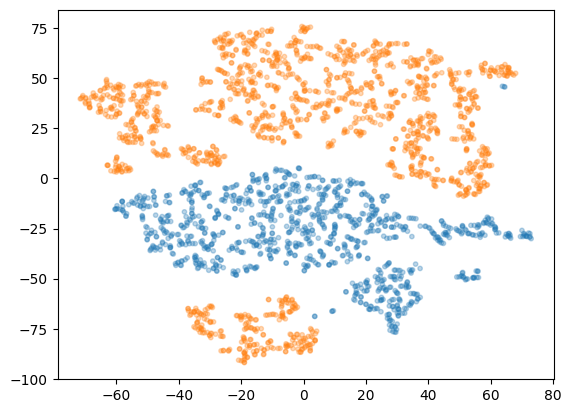

Epoch [71/100] loss:20.4204, loss_reconstruction:17.0840, loss_diff:0.1879, loss_mmd:3.1485: 100%|██████████| 70/70 [00:03<00:00, 17.75it/s]
Epoch [72/100] loss:13.6194, loss_reconstruction:10.6170, loss_diff:0.1493, loss_mmd:2.8531: 100%|██████████| 70/70 [00:04<00:00, 14.30it/s]
Epoch [73/100] loss:16.9796, loss_reconstruction:14.0330, loss_diff:0.1413, loss_mmd:2.8054: 100%|██████████| 70/70 [00:04<00:00, 14.36it/s]
Epoch [74/100] loss:12.7616, loss_reconstruction:9.8061, loss_diff:0.1720, loss_mmd:2.7835: 100%|██████████| 70/70 [00:05<00:00, 12.79it/s]
Epoch [75/100] loss:13.8432, loss_reconstruction:10.9982, loss_diff:0.1447, loss_mmd:2.7003: 100%|██████████| 70/70 [00:04<00:00, 14.84it/s]
Epoch [76/100] loss:16.9709, loss_reconstruction:14.0850, loss_diff:0.1371, loss_mmd:2.7489: 100%|██████████| 70/70 [00:04<00:00, 16.34it/s]
Epoch [77/100] loss:18.6693, loss_reconstruction:15.3782, loss_diff:0.2050, loss_mmd:3.0862: 100%|██████████| 70/70 [00:04<00:00, 15.21it/s]
Epoch [78/100]

Plot the shared space...


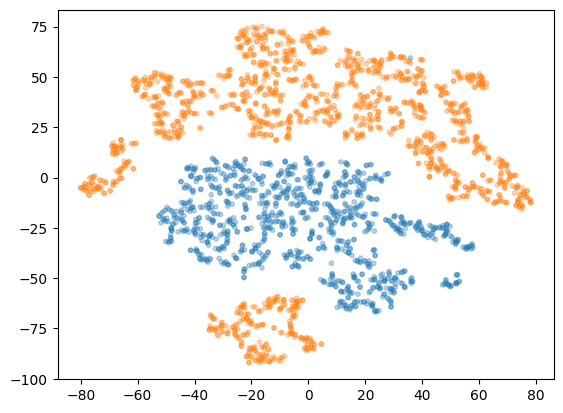

Epoch [81/100] loss:18.0808, loss_reconstruction:15.1647, loss_diff:0.1584, loss_mmd:2.7578: 100%|██████████| 70/70 [00:04<00:00, 15.34it/s]
Epoch [82/100] loss:18.6117, loss_reconstruction:15.5658, loss_diff:0.1271, loss_mmd:2.9188: 100%|██████████| 70/70 [00:04<00:00, 15.75it/s]
Epoch [83/100] loss:14.0233, loss_reconstruction:10.9461, loss_diff:0.1160, loss_mmd:2.9612: 100%|██████████| 70/70 [00:04<00:00, 16.24it/s]
Epoch [84/100] loss:23.9455, loss_reconstruction:20.5347, loss_diff:0.1865, loss_mmd:3.2243: 100%|██████████| 70/70 [00:04<00:00, 15.90it/s]
Epoch [85/100] loss:14.9936, loss_reconstruction:12.1439, loss_diff:0.1365, loss_mmd:2.7133: 100%|██████████| 70/70 [00:04<00:00, 15.48it/s]
Epoch [86/100] loss:17.9948, loss_reconstruction:15.1575, loss_diff:0.1167, loss_mmd:2.7207: 100%|██████████| 70/70 [00:04<00:00, 15.25it/s]
Epoch [87/100] loss:21.1055, loss_reconstruction:18.0114, loss_diff:0.1116, loss_mmd:2.9824: 100%|██████████| 70/70 [00:04<00:00, 16.11it/s]
Epoch [88/100

Plot the shared space...


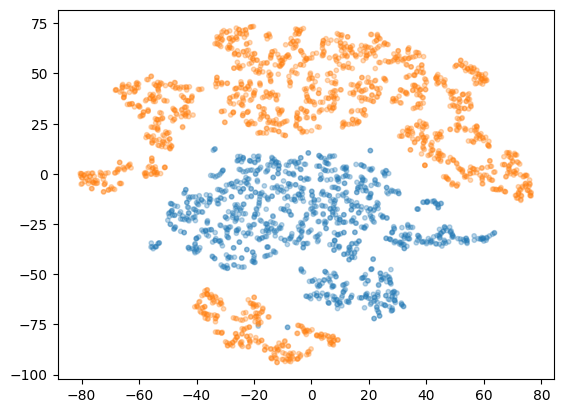

Epoch [91/100] loss:20.3438, loss_reconstruction:17.4634, loss_diff:0.1512, loss_mmd:2.7292: 100%|██████████| 70/70 [00:04<00:00, 14.90it/s]
Epoch [92/100] loss:16.9687, loss_reconstruction:14.0351, loss_diff:0.1624, loss_mmd:2.7712: 100%|██████████| 70/70 [00:04<00:00, 15.11it/s]
Epoch [93/100] loss:14.6390, loss_reconstruction:11.7804, loss_diff:0.1308, loss_mmd:2.7278: 100%|██████████| 70/70 [00:04<00:00, 15.12it/s]
Epoch [94/100] loss:15.9280, loss_reconstruction:13.0616, loss_diff:0.1167, loss_mmd:2.7497: 100%|██████████| 70/70 [00:04<00:00, 14.88it/s]
Epoch [95/100] loss:17.2959, loss_reconstruction:14.2409, loss_diff:0.1577, loss_mmd:2.8973: 100%|██████████| 70/70 [00:04<00:00, 14.91it/s]
Epoch [96/100] loss:12.8977, loss_reconstruction:10.0227, loss_diff:0.0956, loss_mmd:2.7794: 100%|██████████| 70/70 [00:04<00:00, 15.57it/s]
Epoch [97/100] loss:17.2105, loss_reconstruction:14.5142, loss_diff:0.1004, loss_mmd:2.5960: 100%|██████████| 70/70 [00:04<00:00, 15.55it/s]
Epoch [98/100

Plot the shared space...


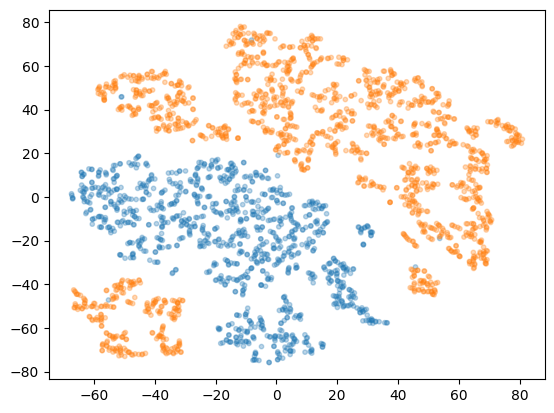

In [59]:
model.train()
plot_per_epoch = 10
tsne = TSNE(n_components=2, perplexity=10)

for epoch in range(EPOCHS):
    progress_bar = tqdm(zip(train_tcga_loader, train_gdsc_loader), total=min(len(train_tcga_loader), len(train_gdsc_loader)))
    model.train()
    for batch_tcga, batch_gdsc in progress_bar:
        batch_tcga = batch_tcga[0]
        batch_gdsc = batch_gdsc[0]
        optimizer.zero_grad()
        out = model(batch_tcga, batch_gdsc)
        loss = out['loss']
        loss.backward()
        optimizer.step()
        progress_bar.set_description(f'Epoch [{epoch+1}/{EPOCHS}] loss:{loss.item():.4f}, loss_reconstruction:{out['loss_reconstruction'].item():.4f}, loss_diff:{out['loss_diff'].item():.4f}, loss_mmd:{out['loss_mmd'].item():.4f}')
    if (epoch+1) % plot_per_epoch == 0 or epoch == 0:
        print('Plot the shared space...')
        model.eval()
        plt.figure()
        with torch.no_grad():
            tcga_embedding = model.shared_encoder(train_tcga).numpy()
            gdsc_embedding = model.shared_encoder(train_gdsc).numpy()
        all_embeddings = np.concat([tcga_embedding, gdsc_embedding], axis=0)
        tsne_embeddings = tsne.fit_transform(all_embeddings)
        colors = ['tab:blue' if i < tcga_embedding.shape[0] else 'tab:orange'  for i in range(tsne_embeddings.shape[0])]
        plt.scatter(tsne_embeddings[:,0],tsne_embeddings[:,1], c=colors, s=10, alpha=0.3)
        plt.show()

In [ ]:
out['gdsc_embedding'].shape

In [ ]:
tsne = TSNE(n_components=2, perplexity=10)
model.eval()
with torch.no_grad():
    out = model(test_tcga, test_gdsc)

print('Plot the shared space...')
plt.figure()
tcga_embedding = out['tcga_embedding'].detach().numpy()
gdsc_embedding = out['gdsc_embedding'].detach().numpy()
all_embeddings = np.concat([tcga_embedding, gdsc_embedding], axis=0)
tsne_embeddings = tsne.fit_transform(all_embeddings)
colors = ['tab:blue' if i < tcga_embedding.shape[0] else 'tab:orange'  for i in range(tsne_embeddings.shape[0])]
plt.scatter(tsne_embeddings[:,0],tsne_embeddings[:,1], c=colors, s=10, alpha=0.3)
plt.show()